In [1]:
%matplotlib inline
import requests
from datetime import datetime
from matplotlib import pyplot as plt
from IPython.display import display, HTML
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from numba import guvectorize
from scipy import signal
from scipy import stats as ss

# utils functions
# ===============

def get_prices(coin_symbol):
    """Get close price.

    Given a symbol crytocurrency retrieve last 2k close prices in USD.

    Parameters
    ----------
    coin_symbol : str

    Returns
    -------
    price_close : pandas.DataFrame
    """
    endpoint = "https://min-api.cryptocompare.com/data/histoday"
    params = dict(fsym=coin_symbol, tsym="USD",limit=2000, aggregate=1)
    out = requests.get(endpoint, params=params).json()['Data']
    data = pd.DataFrame(out).set_index('time')\
                            .loc[:, ['close']]\
                            .rename(columns=dict(close=coin_symbol))
    return data


def get_symbol_close(coin_symbol_list):
    """Get symbol close.

    Given a list of cryptocurrencies symbols retrieve close prices.

    Parameters
    ----------
    coin_symbol_list : list

    Returns
    -------
    price_close : pandas.DataFrame
    """
    d = [get_prices(coin_sym) for coin_sym in coin_symbol_list]
    out = pd.concat(d, axis=1)
    out.index = out.index.map(datetime.utcfromtimestamp)
    return out.asfreq(out.index.inferred_freq)


def multi_column_df_display(list_dfs, cols=3):
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)
    cells = [html_cell.format(content=df.to_html()) for df in list_dfs]
    cells += (cols - (len(list_dfs) % cols)) * [html_cell.format(content="")]
    rows = [html_row.format(content="".join(cells[i:i+cols])) for i in range(0, len(cells), cols)]
    display(HTML(html_table.format(content="".join(rows))))

# hurst functions
# ===============
@guvectorize("float64[:], int64, int64, int64, float64[:]", "(m),(),(),()->()",
             cache=True, nopython=True)
def hurst_rs(x, min_chunksize, max_chunksize, num_chunksize, out):
    """Estimate the Hurst exponent using R/S method.

    Estimates the Hurst (H) exponent using the R/S method from the time series.
    The R/S method consists of dividing the series into pieces of equal size
    `series_len` and calculating the rescaled range. This repeats the process
    for several `series_len` values and adjusts data regression to obtain the H.
    `series_len` will take values between `min_chunksize` and `max_chunksize`,
    the step size from `min_chunksize` to `max_chunksize` can be controlled
    through the parameter `step_chunksize`.

    Parameters
    ----------
    x : 1D-array
        A time series to calculate hurst exponent, must have more elements
        than `min_chunksize` and `max_chunksize`.
    min_chunksize : int
        This parameter allow you control the minimum window size.
    max_chunksize : int
        This parameter allow you control the maximum window size.
    num_chunksize : int
        This parameter allow you control the size of the step from minimum to
        maximum window size. Bigger step means fewer calculations.
    out : 1-element-array, optional
        one element array to store the output.

    Returns
    -------
    H : float
        A estimation of Hurst exponent.

    References
    ----------
    Hurst, H. E. (1951). Long term storage capacity of reservoirs. ASCE
    Transactions, 116(776), 770-808.
    Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002) 27:
    197. http://dx.doi.org/10.1140/epjb/e20020150
    """
    N = len(x)
    max_chunksize += 1
    rs_tmp = np.empty(N, dtype=np.float64)
    chunk_size_list = np.linspace(min_chunksize, max_chunksize, num_chunksize)\
                        .astype(np.int64)
    rs_values_list = np.empty(num_chunksize, dtype=np.float64)

    # 1. The series is divided into chunks of chunk_size_list size
    for i in range(num_chunksize):
        chunk_size = chunk_size_list[i]

        # 2. it iterates on the indices of the first observation of each chunk
        number_of_chunks = int(len(x) / chunk_size)

        for idx in range(number_of_chunks):
            # next means no overlapping
            # convert index to index selection of each chunk
            ini = idx * chunk_size
            end = ini + chunk_size
            chunk = x[ini:end]

            # 2.1 Calculate the RS (chunk_size)
            z = np.cumsum(chunk - np.mean(chunk))
            rs_tmp[idx] = np.divide(
                np.max(z) - np.min(z),  # range
                np.nanstd(chunk)  # standar deviation
            )

        # 3. Average of RS(chunk_size)
        rs_values_list[i] = np.nanmean(rs_tmp[:idx + 1])

    # 4. calculate the Hurst exponent.
    H, c = np.linalg.lstsq(
        a=np.vstack((np.log(chunk_size_list), np.ones(num_chunksize))).T,
        b=np.log(rs_values_list)
    )[0]

    out[0] = H


def hurst_dma(prices, min_chunksize=8, max_chunksize=200, num_chunksize=5):
    """Estimate the Hurst exponent using R/S method.

    Estimates the Hurst (H) exponent using the DMA method from the time series.
    The DMA method consists on calculate the moving average of size `series_len`
    and subtract it to the original series and calculating the standard
    deviation of that result. This repeats the process for several `series_len`
    values and adjusts data regression to obtain the H. `series_len` will take
    values between `min_chunksize` and `max_chunksize`, the step size from
    `min_chunksize` to `max_chunksize` can be controlled through the parameter
    `step_chunksize`.

    Parameters
    ----------
    prices
    min_chunksize
    max_chunksize
    num_chunksize

    Returns
    -------
    hurst_exponent : float
        Estimation of hurst exponent.

    References
    ----------
    Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002) 27:
    197. http://dx.doi.org/10.1140/epjb/e20020150

    """
    max_chunksize += 1
    N = len(prices)
    n_list = np.arange(min_chunksize, max_chunksize, num_chunksize, dtype=np.int64)
    dma_list = np.empty(len(n_list))
    factor = 1 / (N - max_chunksize)
    # sweeping n_list
    for i, n in enumerate(n_list):
        b = np.divide([n - 1] + (n - 1) * [-1], n)  # do the same as:  y - y_ma_n
        noise = np.power(signal.lfilter(b, 1, prices)[max_chunksize:], 2)
        dma_list[i] = np.sqrt(factor * np.sum(noise))

    H, const = np.linalg.lstsq(
        a=np.vstack([np.log10(n_list), np.ones(len(n_list))]).T,
        b=np.log10(dma_list)
    )[0]
    return H


def hurst_dsod(x):
    """Estimate Hurst exponent on data timeseries.

    The estimation is based on the discrete second order derivative. Consists on
    get two different noise of the original series and calculate the standard
    deviation and calculate the slope of two point with that values.
    source: https://gist.github.com/wmvanvliet/d883c3fe1402c7ced6fc

    Parameters
    ----------
    x : numpy array
        time series to estimate the Hurst exponent for.

    Returns
    -------
    h : float
        The estimation of the Hurst exponent for the given time series.

    References
    ----------
    Istas, J.; G. Lang (1994), “Quadratic variations and estimation of the local
    Hölder index of data Gaussian process,” Ann. Inst. Poincaré, 33, pp. 407–436.


    Notes
    -----
    This hurst_ets is data literal traduction of wfbmesti.m of waveleet toolbox
    from matlab.
    """
    y = np.cumsum(np.diff(x, axis=0), axis=0)

    # second order derivative
    b1 = [1, -2, 1]
    y1 = signal.lfilter(b1, 1, y, axis=0)
    y1 = y1[len(b1) - 1:]  # first values contain filter artifacts

    # wider second order derivative
    b2 = [1,  0, -2, 0, 1]
    y2 = signal.lfilter(b2, 1, y, axis=0)
    y2 = y2[len(b2) - 1:]  # first values contain filter artifacts

    s1 = np.mean(y1 ** 2, axis=0)
    s2 = np.mean(y2 ** 2, axis=0)

    return 0.5 * np.log2(s2 / s1)


def hurst_exponent(prices, min_chunksize=8, max_chunksize=200, num_chunksize=5,
                   method='RS'):
    """Estimates Hurst Exponent.

    Estimate the hurst exponent following one of 3 methods. Each method

    Parameters
    ----------
    prices : numpy.ndarray, pandas.Series or pandas.DataFrame
        A time series to estimate hurst exponent.
    min_chunksize : int, optional
        Minimum chunk  size of the original series. This parameter doesn't have
        any effect with DSOD method.
    max_chunksize : int, optional
        Maximum chunk size of the original series. This parameter doesn't have
        any effect with DSOD method.
    step_chunksize : int, optional
        Step used to select next the chunk size which divide the original
        series. This parameter doesn't have any effect with DSOD method.
    method : {'RS', 'DMA', 'DSOD', 'all'}
        The methods can take one of that values,
            RS : rescaled range.
            DMA : deviation moving average.
            DSOD : discrete second order derivative.


    Returns
    -------
    hurst_exponent : float
        Estimation of hurst_exponent according to the method selected.

    References
    ----------
    RS : Hurst, H. E. (1951). Long term storage capacity of reservoirs. ASCE
         Transactions, 116(776), 770-808.
    DMA : Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002)
         27: 197. http://dx.doi.org/10.1140/epjb/e20020150
    DSOD : Istas, J.; G. Lang (1994), “Quadratic variations and estimation of
        the local Hölder index of data Gaussian process,” Ann. Inst. Poincaré,
        33, pp. 407–436.

    Notes
    -----
    The hurst exponent is an estimation which is important because there is no
    data closed equation for it instead we have some methods to estimate it with
    high variations among them.

    See Also
    --------
    hurst_rs, hurst_dma, hurst_dsod
    """
    if len(prices) == 0:
        return np.nan
    # extract array
    arr = prices.__array__()
    # choose data method
    if method == 'RS':
        if prices.ndim > 1:
            h = hurst_rs(np.diff(arr, axis=0).T, min_chunksize, max_chunksize,
                         num_chunksize)
        else:
            h = hurst_rs(np.diff(arr), min_chunksize, max_chunksize,
                         num_chunksize)
    elif method == 'DMA':
        h = hurst_dma(arr, min_chunksize, max_chunksize, num_chunksize)
    elif method == 'DSOD':
        h = hurst_dsod(arr)
    elif method == 'all':
        return [
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'RS'),
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'DMA'),
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'DSOD')
        ]
    else:
        raise NotImplementedError('The method choose is not implemented.')
    
    return h

To show about about persistence we can follow similiar steps as shown in the paper [Persistence in the cryptocurrency market](https://www.sciencedirect.com/science/article/pii/S0275531917309200). I select the same four currencies selected in that paper, that is: Bitcoin, Ethereum, Dash and Litecoin.

You can see [here](https://coinmarketcap.com/coins/) the top crypto currencies by market capitalization.

In [2]:
coin_sym_list = 'BTC ETH DASH LTC'.split()
prices = get_symbol_close(coin_sym_list)
prices = prices.loc['2014':'2017']  # select the same period
prices = prices.where(prices != 0., np.nan)  # convert zeros into NaN's

In [3]:
multi_column_df_display([prices.head(), prices.tail()], 2)

,BTC,ETH,DASH,LTC
time,,,,
2014-01-01,815.94,NaN,NaN,24.77
2014-01-02,856.91,NaN,NaN,26.60
2014-01-03,884.26,NaN,NaN,25.49
2014-01-04,924.69,NaN,NaN,24.05
2014-01-05,1014.74,NaN,NaN,26.01
,BTC,ETH,DASH,LTC
time,,,,
2017-12-27,15416.64,739.94,1133.36,264.07
2017-12-28,14398.70,716.69,1103.06,249.86


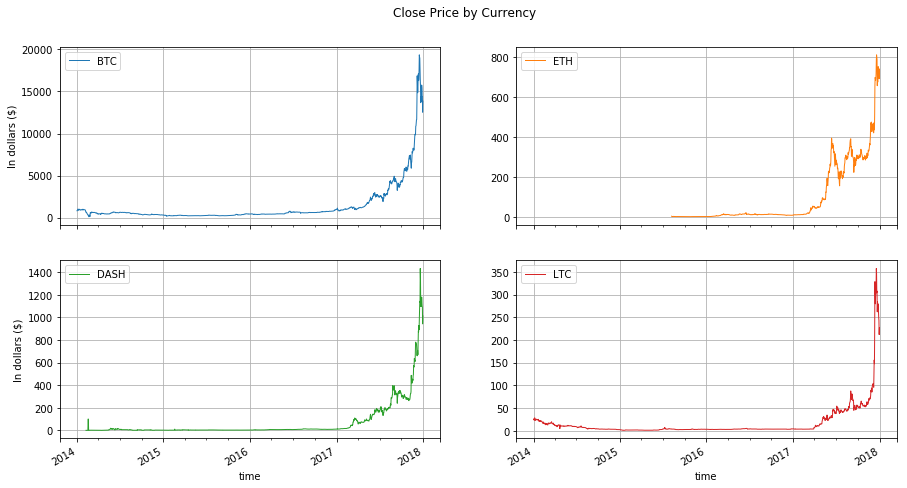

In [4]:
# plot price series
kw = dict(figsize=(15,8), grid=True, subplots=True, layout=(2,2), linewidth=1)
axs = prices.plot(**kw)
[ax.set_ylabel('In dollars ($)') for ax in axs.flat[::2]]
plt.suptitle('Close Price by Currency', y=0.95);

In [5]:
# table hurst with entire series
hurst_methods = [
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='DSOD')),
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='RS')),
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='DMA')),
]
hurst_table = pd.concat(hurst_methods, axis=1)
hurst_table.columns = ['DSOD', 'RS', 'DMA']
hurst_table

/Users/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:303: RuntimeWarning: invalid value encountered in hurst_rs
/Users/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:189: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


,DSOD,RS,DMA
BTC,0.707679,0.574953,0.511099
ETH,0.595606,0.615792,0.462880
DASH,0.426228,0.518237,0.477691
LTC,0.626129,0.583684,0.339087


In [6]:
# the same methodology as shown in the paper.
roll_days = 200
roll_prices = prices.rolling(roll_days)
summary = [
    roll_prices.apply(lambda s: hurst_exponent(s, method='RS')),
    roll_prices.apply(lambda s: hurst_exponent(s, method='DSOD')),
    ]
roll_hurst = pd.concat(summary, axis=1, keys=['RS', 'DSOD'])
roll_hurst = roll_hurst.swaplevel(axis=1)\
                       .asfreq(roll_hurst.index.inferred_freq)\
                       .sort_index(axis=1, level=0)

/Users/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """
/Users/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


In [7]:
roll_hurst[::10].tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2017-11-21  0.482069  0.544024  0.296220  0.507746  0.505230  0.616227   
2017-12-01  0.528388  0.535688  0.294327  0.509229  0.520636  0.655861   
2017-12-11  0.867165  0.487459  0.369463  0.515555  0.464855  0.588835   
2017-12-21  0.960237  0.580247  0.074165  0.547864  0.744188  0.537789   
2017-12-31  0.718286  0.526777  0.405695  0.504282  0.587812  0.578219   

                 LTC            
                DSOD        RS  
time                            
2017-11-21  0.512576  0.521380  
2017-12-01  0.484793  0.514353  
2017-12-11  0.115036  0.506990  
2017-12-21  0.780719  0.527782  
2017-12-31  0.634517  0.523565

In [8]:
roll_hurst[::20].tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2017-10-12  0.314670  0.587466  0.352346  0.541247  0.514698  0.672968   
2017-11-01  0.381975  0.572908  0.360915  0.513383  0.516134  0.636427   
2017-11-21  0.482069  0.544024  0.296220  0.507746  0.505230  0.616227   
2017-12-11  0.867165  0.487459  0.369463  0.515555  0.464855  0.588835   
2017-12-31  0.718286  0.526777  0.405695  0.504282  0.587812  0.578219   

                 LTC            
                DSOD        RS  
time                            
2017-10-12  0.545082  0.404600  
2017-11-01  0.546198  0.490102  
2017-11-21  0.512576  0.521380  
2017-12-11  0.115036  0.506990  
2017-12-31  0.634517  0.523565

In [9]:
roll_hurst[::30].tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2017-08-13  0.382158  0.605394  0.498118  0.532037  0.591661  0.689013   
2017-09-12  0.365139  0.545146  0.338633  0.497254  0.560318  0.679218   
2017-10-12  0.314670  0.587466  0.352346  0.541247  0.514698  0.672968   
2017-11-11  0.463257  0.551190  0.371233  0.484607  0.505032  0.628059   
2017-12-11  0.867165  0.487459  0.369463  0.515555  0.464855  0.588835   

                 LTC            
                DSOD        RS  
time                            
2017-08-13  0.669584  0.543010  
2017-09-12  0.614458  0.479948  
2017-10-12  0.545082  0.404600  
2017-11-11  0.539590  0.502032  
2017-12-11  0.115036  0.506990

In [10]:
roll_hurst[::50].tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2017-06-04  0.619325  0.490984  0.675981  0.689466  0.769564  0.592425   
2017-07-24  0.332061  0.645878  0.522786  0.557383  0.629804  0.674480   
2017-09-12  0.365139  0.545146  0.338633  0.497254  0.560318  0.679218   
2017-11-01  0.381975  0.572908  0.360915  0.513383  0.516134  0.636427   
2017-12-21  0.960237  0.580247  0.074165  0.547864  0.744188  0.537789   

                 LTC            
                DSOD        RS  
time                            
2017-06-04  0.833918  0.565514  
2017-07-24  0.685817  0.576338  
2017-09-12  0.614458  0.479948  
2017-11-01  0.546198  0.490102  
2017-12-21  0.780719  0.527782

In [11]:
roll_hurst[::10].mean()

BTC   DSOD    0.557143
      RS      0.564250
DASH  DSOD    0.311026
      RS      0.480263
ETH   DSOD    0.499060
      RS      0.605109
LTC   DSOD    0.549495
      RS      0.531483
dtype: float64

In [12]:
roll_hurst[::20].mean()

BTC   DSOD    0.554200
      RS      0.565186
DASH  DSOD    0.315280
      RS      0.481267
ETH   DSOD    0.486015
      RS      0.604105
LTC   DSOD    0.541302
      RS      0.534174
dtype: float64

In [13]:
roll_hurst[::30].mean()

BTC   DSOD    0.562905
      RS      0.564397
DASH  DSOD    0.325713
      RS      0.482512
ETH   DSOD    0.501971
      RS      0.604946
LTC   DSOD    0.533700
      RS      0.532167
dtype: float64

In [14]:
roll_hurst[::50].mean()

BTC   DSOD    0.556474
      RS      0.559743
DASH  DSOD    0.308536
      RS      0.479146
ETH   DSOD    0.532467
      RS      0.595328
LTC   DSOD    0.545030
      RS      0.534068
dtype: float64

In [15]:
roll_hurst[::10].median()

BTC   DSOD    0.562392
      RS      0.571661
DASH  DSOD    0.349001
      RS      0.475941
ETH   DSOD    0.513537
      RS      0.617123
LTC   DSOD    0.615257
      RS      0.536764
dtype: float64

In [16]:
roll_hurst[::20].median()

BTC   DSOD    0.572412
      RS      0.569326
DASH  DSOD    0.362080
      RS      0.470592
ETH   DSOD    0.509192
      RS      0.617123
LTC   DSOD    0.617567
      RS      0.544525
dtype: float64

In [17]:
roll_hurst[::30].median()

BTC   DSOD    0.554566
      RS      0.563880
DASH  DSOD    0.364722
      RS      0.484607
ETH   DSOD    0.512378
      RS      0.620084
LTC   DSOD    0.610911
      RS      0.536441
dtype: float64

In [18]:
roll_hurst[::50].median()

BTC   DSOD    0.568702
      RS      0.559212
DASH  DSOD    0.340578
      RS      0.475941
ETH   DSOD    0.528724
      RS      0.605222
LTC   DSOD    0.617552
      RS      0.530383
dtype: float64

In [19]:
roll_hurst[::10].mean(level=0, axis=1);

In [20]:
roll_hurst[::20].mean(level=0, axis=1);

In [21]:
roll_hurst[::30].mean(level=0, axis=1);

In [22]:
roll_hurst[::50].mean(level=0, axis=1);

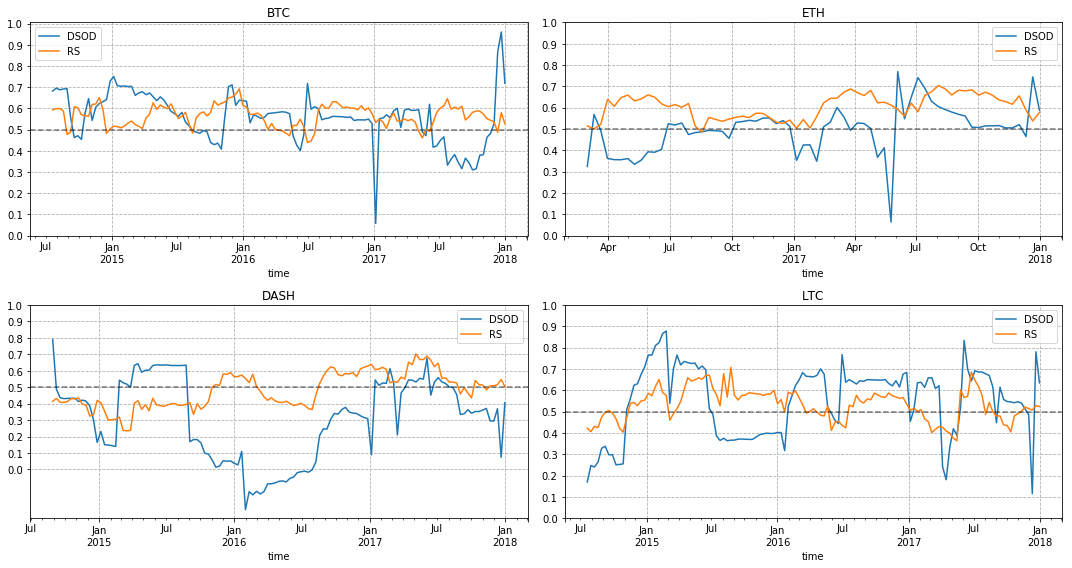

In [23]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::10].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

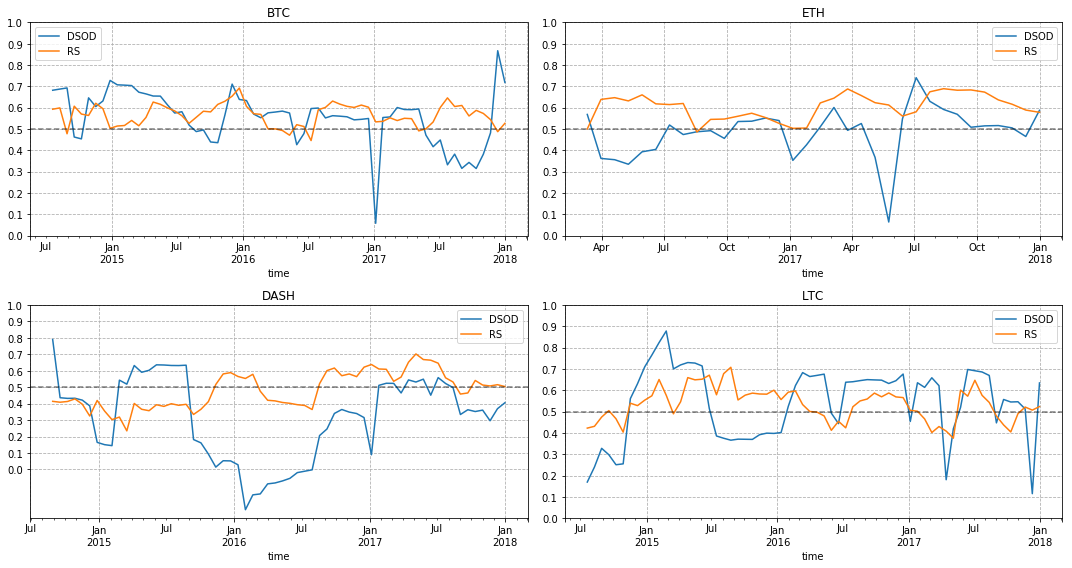

In [24]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::20].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

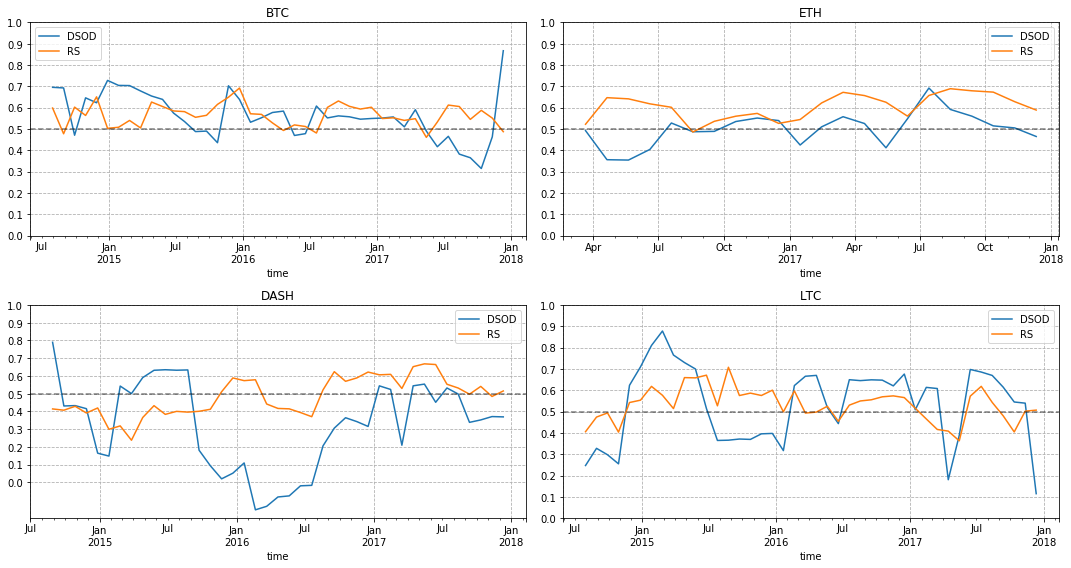

In [25]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::30].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

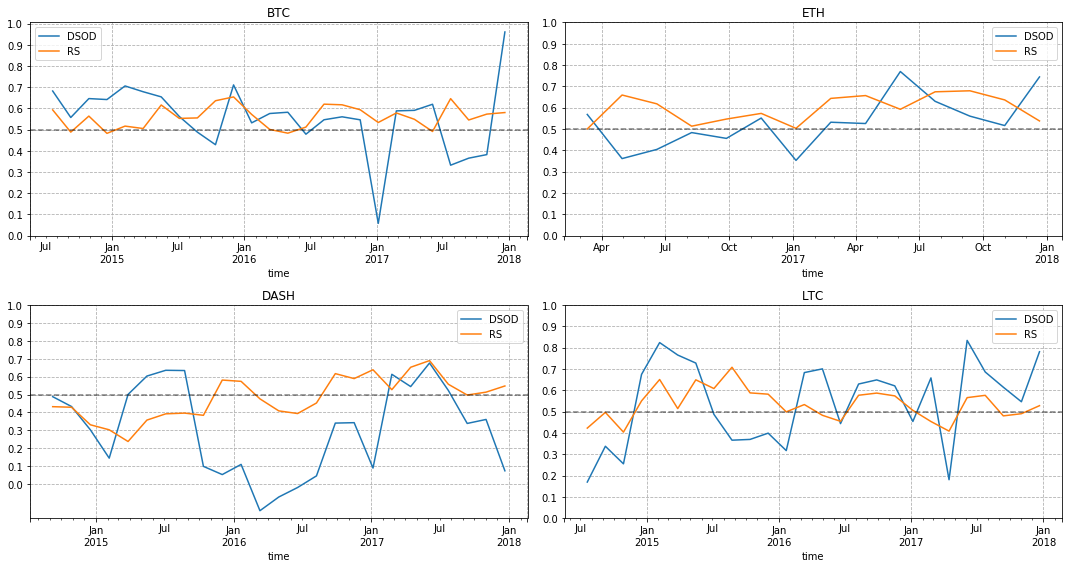

In [26]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::50].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [27]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(10).mean()
ma_roll_hurst.tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2017-12-27  0.894761  0.564711  0.392001  0.541069  0.671275  0.557658   
2017-12-28  0.884157  0.565923  0.393678  0.541357  0.664006  0.560891   
2017-12-29  0.873718  0.568854  0.393875  0.540134  0.656135  0.562350   
2017-12-30  0.858597  0.565896  0.410184  0.535028  0.646245  0.564189   
2017-12-31  0.834402  0.560549  0.443337  0.530669  0.630608  0.568232   

                 LTC            
                DSOD        RS  
time                            
2017-12-27  0.718730  0.523193  
2017-12-28  0.708108  0.523662  
2017-12-29  0.701711  0.524519  
2017-12-30  0.689026  0.524227  
2017-12-31  0.674405  0.523805

In [28]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(20).mean()
ma_roll_hurst.tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2017-12-27  0.859220  0.536086  0.407029  0.538143  0.635900  0.567442   
2017-12-28  0.884163  0.538462  0.410441  0.538549  0.640802  0.568231   
2017-12-29  0.886729  0.542664  0.412786  0.537758  0.644646  0.568224   
2017-12-30  0.886241  0.544530  0.414479  0.537945  0.648782  0.568345   
2017-12-31  0.878797  0.546496  0.416291  0.537382  0.654930  0.567814   

                 LTC            
                DSOD        RS  
time                            
2017-12-27  0.635753  0.524784  
2017-12-28  0.648000  0.524466  
2017-12-29  0.649712  0.522696  
2017-12-30  0.658431  0.522786  
2017-12-31  0.684405  0.523615

In [29]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(30).mean()
ma_roll_hurst.tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2017-12-27  0.749310  0.533267  0.380872  0.532286  0.599353  0.585194   
2017-12-28  0.759623  0.535069  0.387887  0.533045  0.603633  0.584502   
2017-12-29  0.769818  0.536893  0.395313  0.533146  0.607544  0.582272   
2017-12-30  0.778747  0.536237  0.400412  0.533267  0.611409  0.579819   
2017-12-31  0.785077  0.535940  0.404124  0.533102  0.613648  0.577231   

                 LTC            
                DSOD        RS  
time                            
2017-12-27  0.587288  0.519534  
2017-12-28  0.593117  0.520753  
2017-12-29  0.599653  0.521720  
2017-12-30  0.605656  0.522102  
2017-12-31  0.610646  0.522409

In [30]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(50).mean()
ma_roll_hurst.tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2017-12-27  0.634851  0.538145  0.347581  0.518683  0.562031  0.601722   
2017-12-28  0.643236  0.537884  0.349500  0.520109  0.564564  0.601045   
2017-12-29  0.652323  0.538400  0.351450  0.521075  0.566915  0.599839   
2017-12-30  0.659519  0.537928  0.353058  0.521158  0.569063  0.598790   
2017-12-31  0.664619  0.537440  0.353747  0.521551  0.570719  0.597793   

                 LTC            
                DSOD        RS  
time                            
2017-12-27  0.560649  0.517325  
2017-12-28  0.563153  0.517713  
2017-12-29  0.565632  0.518328  
2017-12-30  0.567926  0.518673  
2017-12-31  0.569825  0.519103

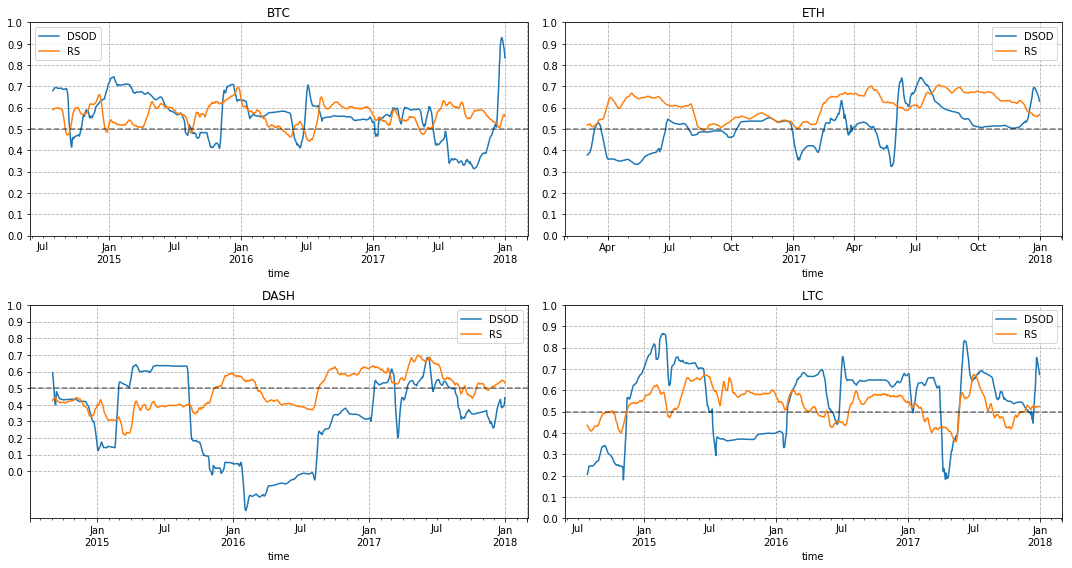

In [31]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(10).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

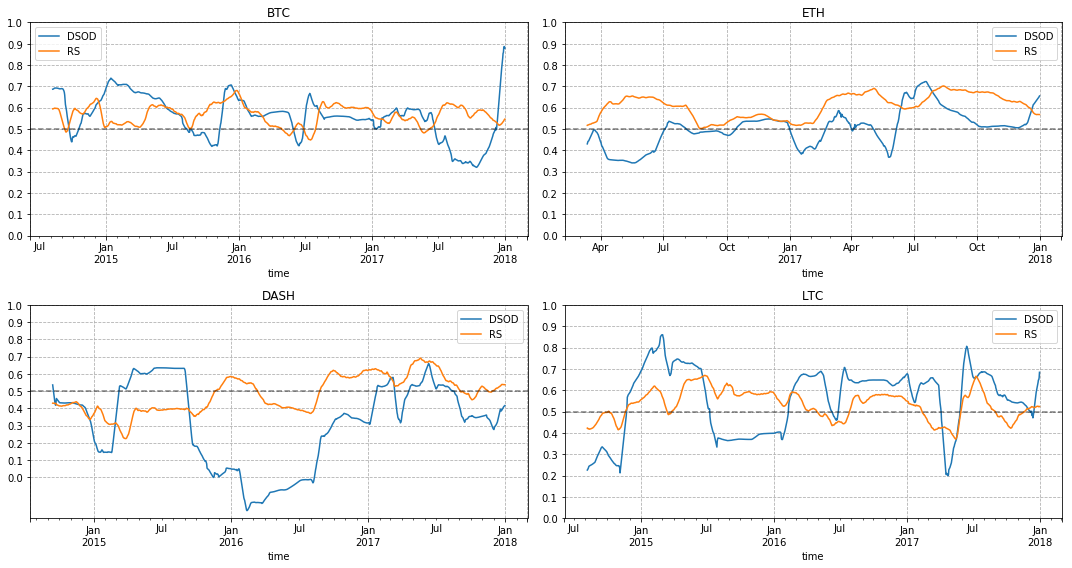

In [32]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(20).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

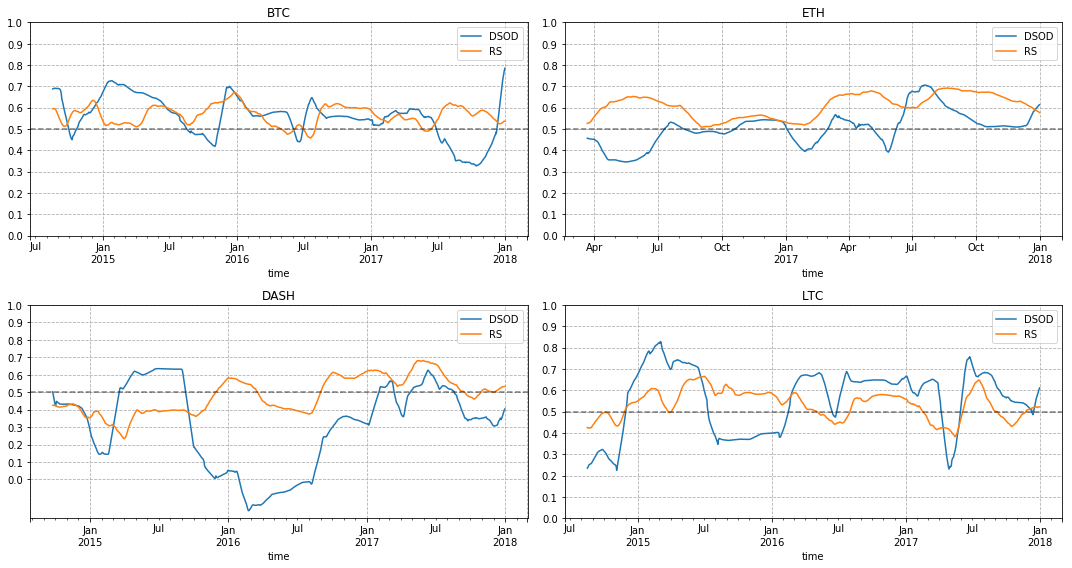

In [33]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(30).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

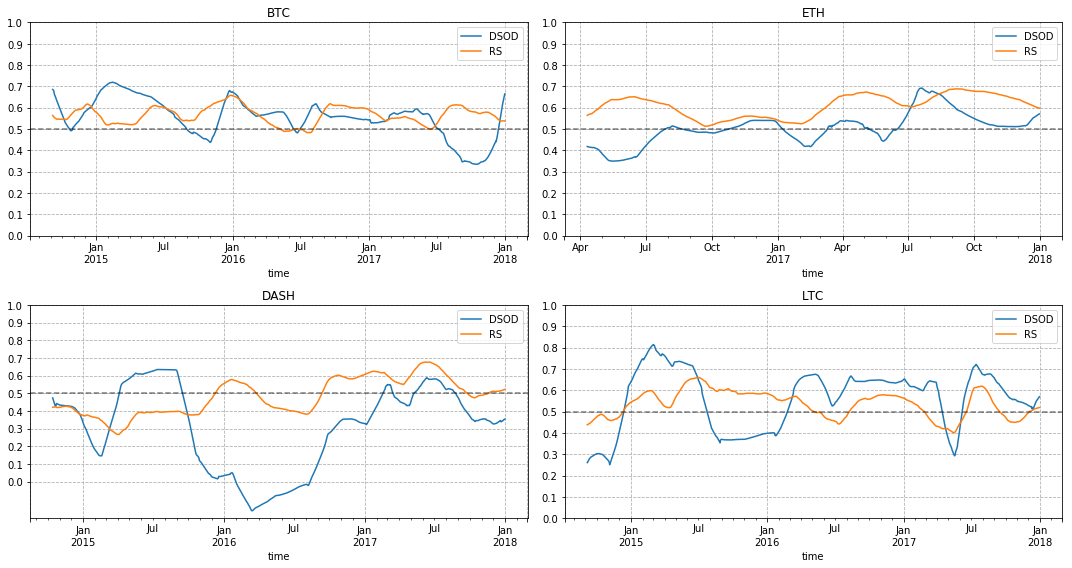

In [34]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(50).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

# REFERENCES

- Caporale, G. M., Gil-Alana, L., & Plastun, A. (2017). Persistence in the Cryptocurrency Market. https://www.sciencedirect.com/science/article/pii/S0275531917309200
- H.E. Hurst, 1951, “Long-term storage of reservoirs: an experimental study,” Transactions of the American Society of Civil Engineers, Vol. 116, pp. 770-799.
- Bo Qian, Khaled Rasheed, 2004, “Hurst Exponent and financial market predictability,” IASTED conference on “Financial Engineering and Applications”(FEA 2004), pp. 203-209,
- Mandelbrot, Benoit B., 2004, “The (Mis)Behavior of Markets, A Fractal View of Risk, Ruin and Reward,” Basic Books, 2004.
